# MobileNet

In [42]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
from tensorflow.keras.applications import mobilenet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 취득

In [47]:
# https://drive.google.com/file/d/1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F/view?usp=sharing
# https://drive.google.com/file/d/1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F/view?usp=sharing
import gdown, os, zipfile

file_id = '1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F'
gdown.download(f'http://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'hair-loss-or'
os.makedirs(dir, exist_ok=True)

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)

Downloading...
From (original): http://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F
From (redirected): https://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F&confirm=t&uuid=5ac9e459-c510-421b-9f3b-ed418467bc65
To: /content/file.zip
100%|██████████| 1.25G/1.25G [00:06<00:00, 186MB/s] 


## 메타데이터

In [68]:
from sklearn.model_selection import train_test_split
import os
def load_data(base_dir = 'hair-loss-or/Training'):
  images = []
  labels = []
  class_names = []

  for class_name in os.listdir(base_dir):
    class_name_path = os.path.join(base_dir, class_name)

    if os.path.isdir(class_name_path):
      for image_name in os.listdir(class_name_path):
        image_path = os.path.join(class_name_path, image_name)
        images.append(image_path)
        labels.append(class_name)

  return images, np.array(labels)

images, labels  = load_data()

# images.shape, labels.shape


### 이미지 resize

In [69]:
import tensorflow as tf
import cv2

# 리사이즈 크기 설정
IMAGE_SIZE = (224, 224)

# 결과 저장 리스트
processed_images = []

# 이미지 경로 리스트 반복 - 이미지 읽기
for image_path in images:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    processed_images.append(image)

# 최종 이미지
images = np.array(processed_images)

print(images.shape)
print(labels.shape)

(5402, 224, 224, 3)
(5402,)


In [76]:
from tensorflow.keras.regularizers import l2


base_model = applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

model = models.Model(base_model.input, output)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,432,420 (9.28 MB)

 Trainable params: 2,398,308 (9.15 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Sequence Subclass 작성

In [77]:
# 사진 - 640 x 480
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

BATCH_SIZE = 64
IMAGE_SIZE = 224

class HairLossSequence(Sequence):
  def __init__(self, images, labels, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.preprocess_function = preprocess_function
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None

    batch_images = np.zeros((this_batch_images.shape[0], self.image_size, self.image_size, 3), dtype=np.float32)


    for i in range(this_batch_images.shape[0]):
      image = this_batch_images[i]

      # 리사이즈
      # image = cv2.resize(image, (self.image_size, self.image_size))

      # 스케일링
      if self.preprocess_function is not None:
        image = self.preprocess_function(image)

      batch_images[i] = image
    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self):
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)


### 데이터 셋 분할

In [78]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 훈련 / 테스트셋 분할
tr_images, test_images, tr_labels, test_labels = train_test_split(images, labels, test_size=0.1, random_state=0, stratify=labels)

print(tr_images.shape, tr_labels.shape, test_images.shape, test_labels.shape)

# 훈련 / 검증용 분할
tr_images, val_images, tr_labels, val_labels = train_test_split(tr_images, tr_labels, test_size=0.111, random_state =0)
tr_images.shape, tr_labels.shape, val_images.shape, val_labels.shape, test_images.shape, test_labels.shape

# one-hot encording
tr_labels = to_categorical(tr_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

print(tr_images.shape, val_images.shape, tr_labels.shape, val_labels.shape)

(4861, 224, 224, 3) (4861,) (541, 224, 224, 3) (541,)
(4321, 224, 224, 3) (540, 224, 224, 3) (4321, 4) (540, 4)


In [79]:
# 학습/검증/평가용 Sequence 객체 준비
from tensorflow.keras.applications.mobilenet import preprocess_input


tr_seq = HairLossSequence(tr_images, tr_labels, preprocess_function=preprocess_input, shuffle=True)
val_seq = HairLossSequence(val_images, val_labels, preprocess_function=preprocess_input, shuffle=False)
test_seq = HairLossSequence(test_images, test_labels, preprocess_function=preprocess_input, shuffle=False)

tr_batch_images, tr_batch_labels = next(iter(tr_seq))
tr_batch_images.shape, tr_batch_labels.shape

# tr_batch_labels[:30]

((64, 224, 224, 3), (64, 4))

## Sequence 객체 준비

In [80]:
# 학습/검증/평가용 Sequence 객체 준비
from tensorflow.keras.applications.mobilenet import preprocess_input


tr_seq = HairLossSequence(tr_images, tr_labels, preprocess_function=preprocess_input, shuffle=True)
val_seq = HairLossSequence(val_images, val_labels, preprocess_function=preprocess_input, shuffle=False)
test_seq = HairLossSequence(test_images, test_labels, preprocess_function=preprocess_input, shuffle=False)

tr_batch_images, tr_batch_labels = next(iter(tr_seq))
tr_batch_images.shape, tr_batch_labels.shape

((64, 224, 224, 3), (64, 4))

# 미세조정 1단계

In [ ]:
# @title 미세조정 1단계 : 분류층 레이어만 학습
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 특성추출층 freeze
for layer in model.layers[:-5]:
  layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001), # 'adam' -> Adam() 실제 객체로 변환후 학습이 진행되고 있다?
    metrics=['accuracy']
)

early_stopping_cb = EarlyStopping(patience=6, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# 학습
history = model.fit(
    tr_seq,
    epochs=40,
    validation_data=val_seq,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb])

# 학습결과 시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, accuracy = model.evaluate(test_seq)
print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.4484 - loss: 1.6670 - val_accuracy: 0.7148 - val_loss: 0.8868 - learning_rate: 0.0010
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.6714 - loss: 1.0209 - val_accuracy: 0.7185 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7160 - loss: 0.8813 - val_accuracy: 0.7611 - val_loss: 0.7668 - learning_rate: 0.0010
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.7231 - loss: 0.8391 - val_accuracy: 0.7685 - val_loss: 0.7129 - learning_rate: 0.0010
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7414 - loss: 0.7941 - val_accuracy: 0.7685 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7390 - loss: 0.7739 - val_accuracy: 0.7704 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.7670 - loss: 0.7320 - val_accu

In [75]:
model.save(f'MobileNetV2.loss-{loss:.2f}-accuracy-{accuracy:.2f}.h5')

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 584ms/step - accuracy: 0.6191 - loss: 1.2530 - val_accuracy: 0.5108 - val_loss: 1.1398 - learning_rate: 1.0000e-04
Epoch 2/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.7237 - loss: 0.8107 - val_accuracy: 0.2425 - val_loss: 1.4717 - learning_rate: 1.0000e-04
Epoch 3/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7827 - loss: 0.6423 - val_accuracy: 0.1747 - val_loss: 1.9610 - learning_rate: 1.0000e-04
Epoch 4/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8349 - loss: 0.5107
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8350 - loss: 0.5105 - val_accuracy: 0.2610 - val_loss: 1.7960 - learning_rate: 1.0000e-04
Epoch 5/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8779 - loss: 0.3947 - val_accuracy: 0.2724 - val_loss: 1.9773 - learning_rate: 5.0000e-05
Epoch 6/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8969 - loss: 0.359

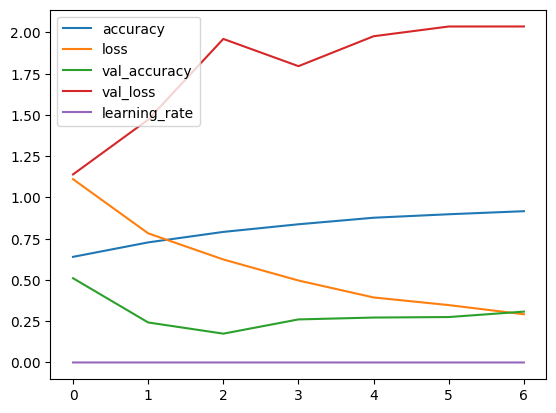

7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4907 - loss: 1.1596

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - accuracy: 0.4894 - loss: 1.1610
loss: 1.1654, accuracy: 0.4861


In [ ]:
# @title 미세조정 2단계 : 특성추출층/분류층 레이어 모두 학습
# - 특성추출층에 있는 BatchNormalization 학습 제외
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 특성추출층 unfreeze
for layer in model.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001), # 기존 lr보다 1/10로 감소
    metrics=['accuracy']
)

early_stopping_cb = EarlyStopping(patience=6, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# 학습
history = model.fit(
    tr_seq,
    epochs=35,
    validation_data=val_seq,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb])

# 학습결과 시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, accuracy = model.evaluate(test_seq)
print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}')

In [ ]:
model.save(f'MobileNetV2.loss-{loss:.2f}-accuracy-{accuracy:.2f}.h5')

In [ ]:
# @ 사용되는 패키지 조회
!pip freeze > requirements.txt

In [ ]:
# @title 파이썬 버전 확인
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
